In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def get_price(tick,res):
    res=str(res)
    hist=requests.get('https://ftx.com/api/markets/'+tick+'-PERP/candles?resolution='+res+'&start_time='+'0'+'&limit=1000').json()
    hist=pd.DataFrame(hist['result'])
    hist.drop(['startTime'], axis = 1, inplace=True)
    return hist

def get_time(hist):
    aux=hist.copy(deep=True)
    aux['time'] = pd.to_datetime(aux['time'], unit='ms')
    aux.set_index('time', inplace=True)
    return aux

def get_initime(hist):
    aux=hist.copy(deep=True)
    aux['time'] = pd.to_datetime(aux['time'], unit='ms')
    return aux['time'][0]

def get_time(hist,i):
    aux=hist.copy(deep=True)
    aux['time'] = pd.to_datetime(aux['time'], unit='ms')
    return aux['time'][i]

# Calculate cointegration constant

In [3]:
def coint_test(tick1,tick2,res):
    A=get_price(tick1,res)
    B=get_price(tick2,res)
    if not get_initime(B)==get_initime(A):
        print('Different initial time')
        return 
    X = np.stack((np.log(A['close']), np.log(B['close'])), axis=0)
    cov=np.cov(X)
    #print(cov)
    covAB=cov[0,1]
    varA=cov[0,0]
    varB=cov[1,1]
    cor=covAB/(np.sqrt(varA*varB))
    lAB=covAB/varB #res=log(A)-lAB*log(B)
    lBA=covAB/varA #res=log(B)-lBA*log(A)
    spreadAB=np.log(A['close'])-lAB*np.log(B['close'])
    muAB=np.mean(spreadAB)
    spreadBA=np.log(B['close'])-lBA*np.log(A['close'])
    muBA=np.mean(spreadBA)
    return cor,lAB,lBA,muAB,muBA,spreadAB,spreadBA

def print_spread(tick1,tick2,res):
    aux=coint_test(tick1,tick2,res)
    if aux[1]>aux[2]:
        print('We are gonna use A-lAB*B with correlation='+str(aux[0])+' and lambda_AB='+str(aux[1]))
        plt.plot(aux[5]-aux[3])
        return aux[5]
    else :
        print('We are gonna use B-lBA*A with correlation='+str(aux[0])+' and lambda_BA='+str(aux[2]))
        plt.plot(aux[6]-aux[4])
        return aux[6]

## Augmented Dickey–Fuller test

In [4]:
import statsmodels.api as stat
import statsmodels.tsa.stattools as ts

In [5]:
def adfuller_test(tick1,tick2,res):
    A=get_price(tick1,res)
    B=get_price(tick2,res)
    aux=stat.OLS(A['close'],B['close']).fit()
    c_t=ts.adfuller(aux.resid)
    if c_t[0]<=c_t[4]['10%'] and c_t[1]<0.1:
        print(tick1+' and '+tick2+' are cointegrated')
    else :
        print(tick1+' and '+tick2+' are not cointegrated')

# Profit function

In [33]:
# Counts how many times the series mean reverts
def cross_count(spread,delta):
    signal=0
    count=0
    mu=np.mean(spread)
    long=[]
    close=[]
    short=[]
    for i in range(len(spread)):
        if spread[i]<=-delta+mu and signal==0:
            signal=1
            long.append(i)
        elif spread[i]>=delta+mu and signal==0:
            signal=-1
            short.append(i)
        if signal==1 and spread[i]>=mu:
            count=count+1
            signal=0
            close.append(i)
        elif signal==-1 and spread[i]<=mu:
            count=count+1
            signal=0
            close.append(i)
    return count,long,short,close
# Return is gonna be delta times the amount of mean reverts
def profit_cross(spread,delta):
    return delta*cross_count(spread,delta)[0]

In [7]:
# Returns the profits, number of mean reverts with different delta values
def profit_array(spread):
    mu=np.mean(spread)
    delta_max=np.max(spread-mu)
    delta_array=np.linspace(0,delta_max,num=50)
    prof=np.zeros(len(delta_array))
    cross=np.zeros(len(delta_array))
    for i in range(len(delta_array)):
        cross[i]=cross_count(spread,delta_array[i])[0]
        prof[i]=delta_array[i]*cross[i]
    return prof,cross,delta_array

In [8]:
#Regularization of number of mean reverts function


# TESTS

We are gonna use B-lBA*A with correlation=0.9577328379080402 and lambda_BA=1.2081147534761043


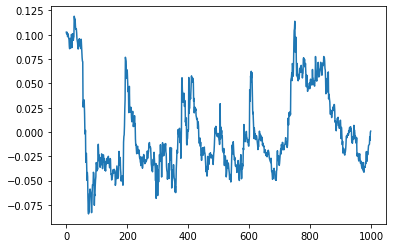

In [15]:
a=print_spread('BCH','OMG',3600)

In [16]:
adfuller_test('BCH','OMG',3600)

BCH and OMG are cointegrated


In [17]:
aux=profit_array(a)

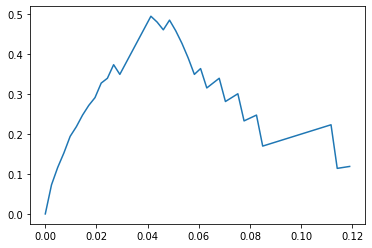

In [18]:
plt.plot(aux[2],aux[0])

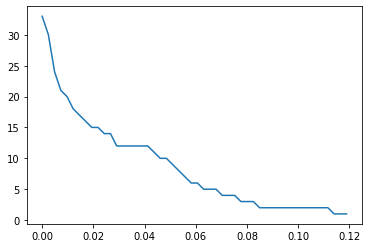

In [19]:
plt.plot(aux[2],aux[1])

In [21]:
b=cross_count(a,0.04)

In [23]:
bch=get_price('BCH',3600)

In [31]:
#3 horas menos en TV
get_time(bch,62)

Timestamp('2021-11-24 13:00:00')

In [29]:
bch['close'][62]

581.65

In [27]:
b

(12,
 [68, 283, 459, 525, 674, 975],
 [0, 194, 379, 402, 602, 737],
 [62, 191, 227, 367, 395, 435, 488, 583, 616, 728, 902, 999])